In [181]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import json

In [182]:
import tensorflow as tf

from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D;
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers

In [183]:
with open("tokenizerRed.json", "r") as jsonfile:
    tokenizer = json.load(jsonfile)

tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer)

In [184]:
with open("dados/tituloTratadoRed.csv", "r") as csvfile:
    titulos = np.genfromtxt(csvfile, delimiter=",")
    titulos = titulos.astype(np.int32)

In [185]:
with open("dados/conteudoTratadoRed.csv", "r") as csvfile:
    conteudos = np.genfromtxt(csvfile, delimiter=",")
    conteudos = conteudos.astype(np.int32)

In [186]:
size = len(conteudos)

xTrain = conteudos[0:int(size*0.8)]
xTest = conteudos[int(size*0.8):]

yTrain = titulos[0:int(size*0.8)]
yTest = titulos[int(size*0.8):]

In [187]:
vocab = len(tokenizer.word_index)

In [188]:
vocab

7392

In [189]:
maxTitle = max(len(tokens) for tokens in titulos)
maxContent = max(len(tokens) for tokens in conteudos)

In [190]:
class SamplingLayer(layers.Layer):
  """Reparameterization Trick z = mu + sigma * epsilon"""

  def call(self, inputs):
    zMean, zLogVar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return zMean + tf.exp(0.5 * zLogVar) * epsilon

In [191]:
def Encoder(latentDim, encoderInputs):
    
  l1 = keras.models.Sequential([
    layers.Embedding(vocab, 128, input_length=maxContent),
    layers.Conv1D(128, 3, activation="relu", strides=1, padding="same"),
    layers.MaxPooling1D(3),
    layers.Conv1D(64, 3, activation="relu", strides=1, padding="same"),
    layers.MaxPooling1D(3),
    layers.Flatten(),
    layers.Dense(256, activation="relu")
  ])

  x = l1(encoderInputs)

  zMean = layers.Dense(latentDim, name="z_mean")(x)
  zLogVar = layers.Dense(latentDim, name="z_log_var")(x)

  z = SamplingLayer()([zMean, zLogVar])

  return keras.Model(encoderInputs, [zMean, zLogVar, z], name="encoder")

encoderInputs = keras.Input(shape=(maxContent, 1))
encoder = Encoder(2, encoderInputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 2141, 1)]            0         []                            
                                                                                                  
 sequential_16 (Sequential)  (None, 256)                  4903360   ['input_17[0][0]']            
                                                                                                  
 z_mean (Dense)              (None, 2)                    514       ['sequential_16[0][0]']       
                                                                                                  
 z_log_var (Dense)           (None, 2)                    514       ['sequential_16[0][0]']       
                                                                                            

In [192]:
def Decoder(latentInputs):

  l1 = keras.models.Sequential([
    layers.Dense(maxTitle, activation="relu", input_shape=(latentInputs.shape[1],)),
    layers.Reshape((maxTitle, 1)),
    layers.Conv1DTranspose(128, 3, activation="relu", strides=1, padding="same"),
    layers.Conv1DTranspose(64, 3, activation="relu", strides=1, padding="same"),
    layers.Conv1DTranspose(1, 3, activation="sigmoid", padding="same", input_shape=(None, maxTitle))
  ])

  return keras.Model(latentInputs, l1(latentInputs), name="decoder")

latentInputs = keras.Input(shape=(2,))
decoder = Decoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 2)]               0         
                                                                 
 sequential_17 (Sequential)  (None, 15, 1)             25390     
                                                                 
Total params: 25390 (99.18 KB)
Trainable params: 25390 (99.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [193]:
def reconstructionLoss(data, reconstructed):
  return keras.losses.categorical_crossentropy(data, reconstructed)   

In [194]:
def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
        -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
        axis=1
  )

In [195]:
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)
  loss2 = klDivergenceLoss(zMean, zLogVar)
  klWeight = 3.0
  return  loss1, loss2, loss1 + klWeight * loss2

In [196]:
print(xTrain.shape, "\n", yTrain.shape)

(78, 2141) 
 (78, 15)


In [197]:
xTrain = np.expand_dims(xTrain, -1).astype("float32") / vocab
yTrain = np.expand_dims(yTrain, -1).astype("float32") / vocab

In [198]:
xTest[0].shape

(2141,)

In [199]:
xTestCategorical = []

for i in range(len(xTest)):
    xTestCategorical.append(tf.keras.utils.to_categorical(xTest[i], num_classes=vocab))

xTestCategorical = np.array(xTestCategorical)

In [200]:
xTestCategorical.shape

(20, 2141, 7392)

In [34]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder

    self.totalLossTracker = keras.metrics.Mean(name="total_loss")
    self.ceLossTracker = keras.metrics.Mean(name="ce_loss")
    self.klLossTracker = keras.metrics.Mean(name="kl_loss")
    
  @property
  def metrics(self):
    return [
        self.totalLossTracker,
        self.ceLossTracker,
        self.klLossTracker
    ]

  def train_step(self, data):

    x, y = data[0]

    with tf.GradientTape() as tape:
        
        zMean, zLogVar, z = self.encoder(x)
        reconstruction = self.decoder(z)

        ceLoss, klLoss, totalLoss = calcTotalLoss(y, reconstruction, zMean, zLogVar)

    grads = tape.gradient(totalLoss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)

    return {
        "total_loss": self.totalLossTracker.result(),
        "ce_loss": self.ceLossTracker.result(),
        "kl_loss": self.klLossTracker.result()
    }

In [35]:
data = [xTrain, yTrain]

In [36]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
history = vae.fit(data, epochs=10, batch_size=1)

Epoch 1/10
396/396 [==============================] - 25s 55ms/step - total_loss: 0.2900 - ce_loss: 0.2880 - kl_loss: 6.4146e-04
Epoch 2/10
396/396 [==============================] - 22s 54ms/step - total_loss: 0.2586 - ce_loss: 0.2586 - kl_loss: 5.3995e-06
Epoch 3/10
396/396 [==============================] - 21s 54ms/step - total_loss: 0.2493 - ce_loss: 0.2493 - kl_loss: 6.5374e-06
Epoch 4/10
396/396 [==============================] - 22s 55ms/step - total_loss: 0.2432 - ce_loss: 0.2432 - kl_loss: 5.1578e-06
Epoch 5/10
396/396 [==============================] - 22s 55ms/step - total_loss: 0.2404 - ce_loss: 0.2404 - kl_loss: 4.0062e-06
Epoch 6/10
396/396 [==============================] - 22s 55ms/step - total_loss: 0.2398 - ce_loss: 0.2398 - kl_loss: 1.8973e-06
Epoch 7/10
396/396 [==============================] - 22s 55ms/step - total_loss: 0.2398 - ce_loss: 0.2398 - kl_loss: 1.4659e-06
Epoch 8/10
396/396 [==============================] - 22s 55ms/step - total_loss: 0.2395 - ce_los

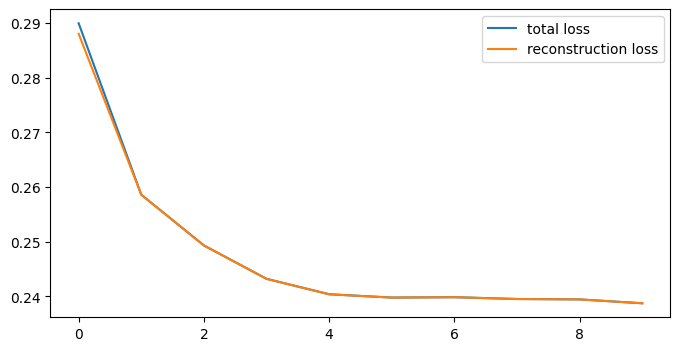

In [37]:
plt.figure(figsize=(8, 4))
plt.plot(history.history.get('total_loss'), label="total loss")
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")
#plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

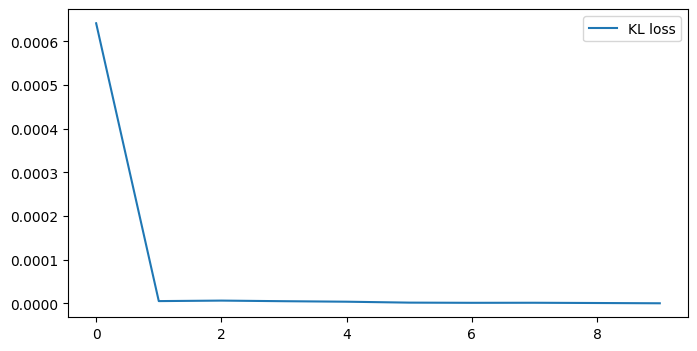

In [38]:
plt.figure(figsize=(8, 4))
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

In [86]:
idx = 12
inputPredict = xTest[idx]
inputPredict = inputPredict.reshape(1, maxContent)

In [87]:
z = vae.encoder.predict([inputPredict])[2]

1/1 [==============================] - 0s 43ms/step


In [88]:
z = np.random.normal(loc=0, scale=4, size=(1,2))

In [89]:
z

array([[-0.55905514,  1.85130848]])

In [90]:
teste = vae.decoder.predict(z)

1/1 [==============================] - 0s 40ms/step


In [91]:
teste = teste.reshape(maxTitle)

In [92]:
teste*vocab

array([2.1964922e+03, 2.7310046e+03, 2.0453079e+03, 2.0159630e+03,
       1.9638931e+03, 1.9492404e+03, 1.9565215e+03, 2.0515554e+03,
       1.9111146e+03, 1.8694054e+03, 1.6002944e+03, 8.7766876e+02,
       2.1293613e+02, 3.9782616e+01, 3.8720627e+00, 1.6666834e-01,
       2.6004527e-02, 1.7093260e+00], dtype=float32)

In [93]:
prediction = (teste*vocab).tolist()
for x in range(maxTitle):
    prediction[x] = round(prediction[x])

predictionsText = tokenizer.sequences_to_texts([prediction])

In [94]:
content = xTest[idx].reshape(maxContent)
content = (content*vocab).tolist()

for x in range(maxContent):
    content[x] = round(content[x])

content = tokenizer.sequences_to_texts([content])

In [95]:
tittle = yTest[idx].reshape(maxTitle)
tittle = (tittle*vocab).tolist()

for x in range(maxTitle):
    tittle[x] = round(tittle[x])

tittle = tokenizer.sequences_to_texts([tittle])

In [96]:
tittle

['junior assunção encara alejandro solano no xfci 5 brasil em junho']

In [97]:
content

['o lutador pernambucano junior assunção que é radicado no espírito santo foi confirmado na luta principal do evento xfci 5 brasil marcado para o dia 7 de junho em são paulo a organização norte americana divulgou o card completo e junior que é irmão do lutador do ufc raphael assunção encara o costa riquenho alejandro mandarina solano o duelo acontece na categoria peso pena até 65 7 kg e aparece com status de super luta da noite que tem mais seis combates confirmados e mais dois ainda em fase de definição dos atletas com 32 anos e um cartel de 14 vitórias e cinco derrotas junior assunção já teve duas passagens pelo ufc entre os anos de 2006 e 2007 retornando em 2011 esta também é a segunda passagem do lutador pelo xtreme fighting championships xfc onde lutou em 2010 já alejandro solano 19 9 e 1nc no mma é mais velho e tem 36 anos o lutador de costa rica atuou em eventos brasileiros como jungle fight e shotoo brasil ambos em 2012 o evento xfci 5 brasil também terá as finais dos torneios 

In [98]:
predictionsText

['encerrou avançar lances parciais filha negativo regras categorias united retirada clima ermírio semana contra e de']